In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


os.listdir() method in python is used to get the list of all files and directories in the specified directory

In [4]:
path="D:/CSV original/LC25000\lung_colon_image_set/lung_image_sets"
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

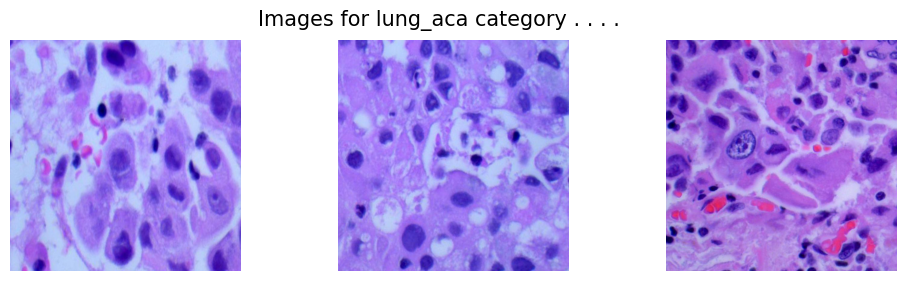

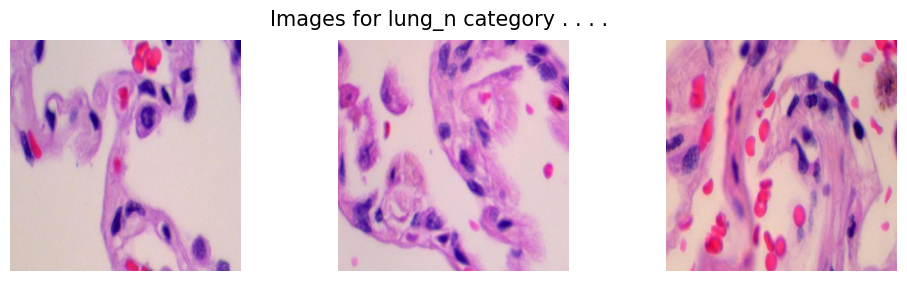

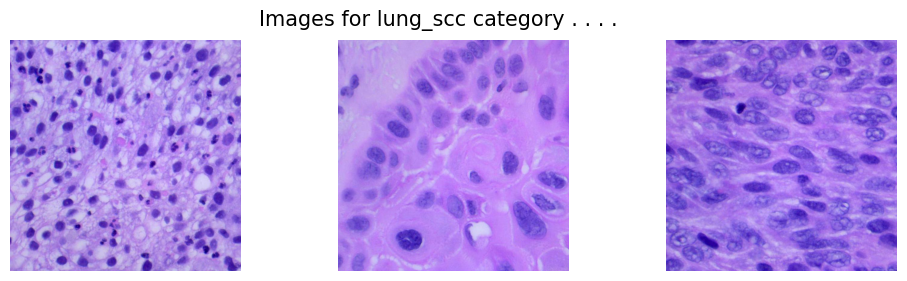

In [5]:
for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize = (12, 3)) #ax can be either a single Axes object, or an array of Axes objects if more than one subplot was created
	fig.suptitle(f'Images for {cat} category . . . .',
				fontsize = 15)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}')) #Image.open:Returns type: An image object
		ax[i].imshow(img)   #matplotlib.axes.Axes.imshow() Function
                            #The Axes.imshow() function in axes module of matplotlib library is also used to display an image or data on a 2D regular raster
		ax[i].axis('off')   #turns down axes lines and numbers
	plt.show()


In this section, we will convert the given images into NumPy arrays of their pixels after resizing them because training a Deep Neural Network on large-size images is highly inefficient in terms of computational cost and time

<h2><span style="color: #ffff99;">hyperparameters:</span></h2>

In [6]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64


<p><span style="color: #99ccff;">In this section, we will convert the given images into NumPy arrays of their pixels after resizing them because training a Deep Neural Network on large-size images is highly inefficient in terms of computational cost and time</span></p>

<h3><span style="color: #ffff99;">One hot encoding:</span></h3>

<h3><span style="color: #ffff99;">glob()</span></h3>
<ul>
<li><span style="color: #ffff99;">In Python, the glob module is used to retrieve&nbsp;files/pathnames&nbsp;matching a specified pattern</span></li>
<li><span style="color: #ffff99;">With glob, we can also use wildcards&nbsp;<code>("*, ?, [ranges])</code>&nbsp;apart from exact string search</span></li>
</ul>

In [7]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg') #returnes all files with jpeg extension

    for image in images:
        img = cv2.imread(image)
        
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)   #Convert the input to an array  
one_hot_encoded_Y = pd.get_dummies(Y).values  #values:Return a Numpy representation of the DataFrame.Only the values in the DataFrame will be returned, the axes labels will be removed
one_hot_encoded_Y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(
X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)


(12000, 256, 256, 3) (3000, 256, 256, 3)


<h2><span style="color: #ffff99;">Model Development:</span></h2>
<p><span style="color: #ffff99;">We will use pre-trained weight for an Inception network which is trained on imagenet dataset</span></p>
<ul>
<li><span style="color: #ffff99;">The base model is the Inception model in this case.</span></li>
<li><span style="color: #ffff99;">The Flatten layer flattens the output of the base model&rsquo;s output.</span></li>
<li><span style="color: #ffff99;">Then we will have two fully connected layers followed by the output of the flattened layer.</span></li>
<li><span style="color: #ffff99;">We have included some&nbsp;<a style="color: #ffff99;" href="https://www.geeksforgeeks.org/tensorflow-js-tf-layers-batchnormalization-function/"><strong>BatchNormalization</strong></a>&nbsp;layers to enable stable and fast training and a&nbsp;<a style="color: #ffff99;" href="https://www.geeksforgeeks.org/dropout-in-neural-networks/"><strong>Dropout</strong></a>&nbsp;layer before the final layer to avoid any possibility of overfitting.</span></li>
<li><span style="color: #ffff99;">The final layer is the output layer which outputs soft probabilities for the three classes</span></li>
</ul>

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# pre_trained_model = InceptionV3(          #all this function is run in colab because imagenet weights is not downloaded in Iran
# 	input_shape = (IMG_SIZE, IMG_SIZE, 3),
# 	weights = 'imagenet',
# 	include_top = False
# )

# pre_trained_model.save_weights('InceptionV3weights.h5')   #this line of code is also run in colab to save the weights

pre_trained_model=tf.keras.applications.InceptionV3(          
	input_shape = (IMG_SIZE, IMG_SIZE, 3),
	weights = None, #loading pre_trained_model with no weight
	include_top = False
    )


pre_trained_model.load_weights(r"D:\CSV original\LC25000\InceptionV3weights.h5")




pre_trained_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [10]:
len(pre_trained_model.layers)


311

<ul>
<li><span style="color: #ffcc00;">This is how deep this model is this also justifies why this model is highly effective in extracting useful features from images which helps us to build classifiers. </span></li>
<li><span style="color: #ffcc00;">The parameters of a model we import are already trained on millions of images and for weeks so, we do not need to train them again</span></li>
</ul>

In [11]:
for layer in pre_trained_model.layers:
    layer.trainable = False


<p><span style="color: #ffcc99;">&lsquo;Mixed7&rsquo; is one of the layers in the inception network whose outputs we will use to build the classifier</span></p>

In [12]:
last_layer = pre_trained_model.get_layer('mixed7') #get_layer returns a layer object 
print(last_layer)
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output #is the output tensor of this layer.
print(last_output)


last layer output shape:  (None, 14, 14, 768)
KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [13]:
x = layers.Flatten()
type(x)

keras.layers.reshaping.flatten.Flatten

In [14]:
x = layers.Flatten()(last_output)

x = layers.Dense(256,activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(3, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)


In [15]:
model.compile(
	optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['accuracy']
)


<ul>
<li>
<div>
<div><strong><span style="color: #99ccff;">ReduceLROnPlateau:</span></strong></div>
</div>
<ul>
<li><span style="color: #ffff99;">Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced</span></li>
</ul>
</li>
<li><span style="color: #99ccff;"><strong>EarlyStopping:</strong></span>
<ul>
<li><span style="color: #ffff99;">Stop training when a monitored metric has stopped improving</span></li>
<li><span style="color: #ffff99;">Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be&nbsp;<code>'loss'</code>, and mode would be&nbsp;<code>'min'</code>. A&nbsp;<code>model.fit()</code>&nbsp;training loop will check at end of every epoch whether the loss is no longer decreasing, considering the&nbsp;<code>min_delta</code>&nbsp;and&nbsp;<code>patience</code>&nbsp;if applicable. Once it's found no longer decreasing,&nbsp;<code>model.stop_training</code>&nbsp;is marked True and the training terminates</span></li>
</ul>
</li>
<li><strong><span style="color: #99ccff;">logs:</span></strong>
<ul>
<li><span style="color: #ffff99;">The quantity to be monitored needs to be available in&nbsp;<code>logs</code>&nbsp;dict. To make it so, pass the loss or metrics at&nbsp;<code>model.compile()</code></span></li>
</ul>
</li>
</ul>

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto 90%\
            so, stopping further training.')
            self.model.stop_training = True

es = EarlyStopping(patience = 3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
					patience = 2,
					factor = 0.5,
					verbose = 1)


In [17]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])


Epoch 1/10
188/188 [==============================] - 1759s 9s/step - loss: 0.3611 - accuracy: 0.8565 - val_loss: 0.9498 - val_accuracy: 0.6580 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.9095
 Validation accuracy has reached upto 90%            so, stopping further training.
188/188 [==============================] - 1757s 9s/step - loss: 0.2206 - accuracy: 0.9095 - val_loss: 0.2297 - val_accuracy: 0.9123 - lr: 0.0010


<ul>
<li>
<div>
<div><strong><span style="color: #ff0000;">Let&rsquo;s visualize the training and validation accuracy and loss with each epoch</span></strong></div>
</div>
</li>
</ul>

In [19]:
print(type(history))
print(type(history.history))
print((history.history))


<class 'keras.callbacks.History'>
<class 'dict'>
{'loss': [0.3611117899417877, 0.2206151932477951], 'accuracy': [0.8565000295639038, 0.909500002861023], 'val_loss': [0.949758768081665, 0.22971826791763306], 'val_accuracy': [0.6579999923706055, 0.9123333096504211], 'lr': [0.001, 0.001]}


In [20]:

history_df = pd.DataFrame(history.history)
history_df


,loss,accuracy,val_loss,val_accuracy,lr
0,0.361112,0.8565,0.949759,0.658000,0.001
1,0.220615,0.9095,0.229718,0.912333,0.001


In [21]:
history_df.loc[:,['loss','val_loss']]


,loss,val_loss
0,0.361112,0.949759
1,0.220615,0.229718


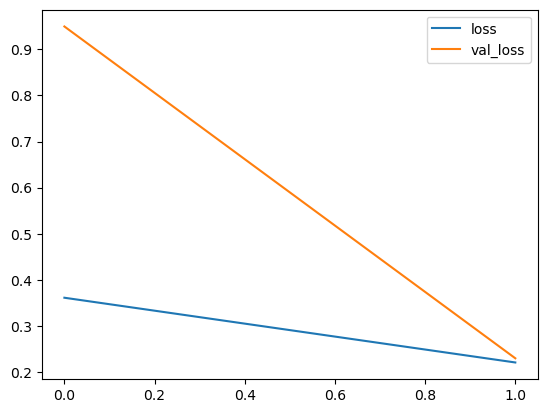

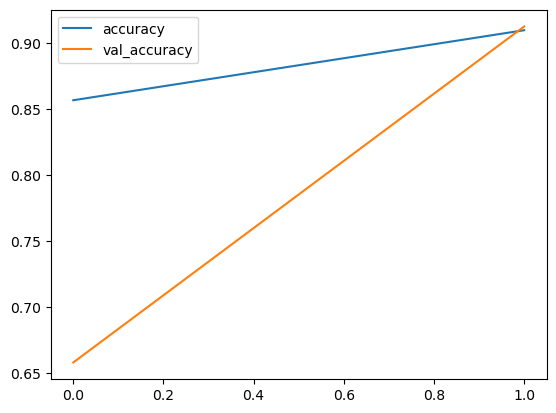

In [22]:

history_df.loc[:,['loss','val_loss']].plot()    #loc:Access a group of rows and columns by label(s) or a boolean array
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


<p><span style="color: #ccffff;">From the above graphs, we can certainly say that the model has not overfitted the training data as the difference between the training and validation accuracy is very low</span></p>

<p><span style="color: #33cccc;">Model Evaluation by other metrics using confusion metrics and classification report </span></p>

In [23]:
Y_pred = model.predict(X_val)
print('y pred',Y_pred)
print('y val',Y_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)
print('y pred',Y_pred)

94/94 [==============================] - 346s 4s/step
y pred [[9.9521768e-01 2.0742204e-05 4.7615529e-03]
 [1.8063939e-01 2.5205183e-04 8.1910855e-01]
 [3.3535026e-03 1.3857010e-06 9.9664503e-01]
 ...
 [3.8861034e-03 9.9573755e-01 3.7630164e-04]
 [1.1231581e-03 9.9882382e-01 5.2928022e-05]
 [3.3407308e-05 9.9996483e-01 1.8455681e-06]]
y val [[1 0 0]
 [0 0 1]
 [0 0 1]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]
y pred [0 2 2 ... 1 1 1]


In [26]:
print(type(Y_pred))
Y_pred.shape

<class 'numpy.ndarray'>


(3000,)

In [27]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[866,   2, 119],
       [ 94, 882,   1],
       [ 47,   0, 989]], dtype=int64)

In [28]:
print(metrics.classification_report(Y_val, Y_pred,	#classification_report:Text summary of the precision, recall, F1 score for each class
									target_names=classes))	#target_names:Optional display names matching the labels


              precision    recall  f1-score   support

    lung_aca       0.86      0.88      0.87       987
      lung_n       1.00      0.90      0.95       977
    lung_scc       0.89      0.95      0.92      1036

    accuracy                           0.91      3000
   macro avg       0.92      0.91      0.91      3000
weighted avg       0.92      0.91      0.91      3000

